In [1]:
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.nn as dglnn
from dgl import AddSelfLoop
from dgl.data import CoraGraphDataset
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import dgl
import dgl.function as fn
from dgl import DGLGraph


In [3]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata["h"] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata["h"]
            return self.linear(h)


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(1433, 16)
        self.layer2 = GCNLayer(16, 7)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x

In [5]:
net = Net()
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=True)
  )
)


In [6]:
dataset = CoraGraphDataset()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [7]:
import pandas as pd

g = dataset[0]
feats = g.ndata['feat']
labels = g.ndata['label']
data = pd.DataFrame({'feats': torch.tensor(range(2708)), 'labels': labels})
data.head()

,feats,labels
0,0,3
1,1,4
2,2,4
3,3,0
4,4,3


In [8]:

def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
    
gcn_msg = fn.copy_u(u="h", out="m")
gcn_reduce = fn.sum(msg="m", out="h")


In [9]:
dataset = CoraGraphDataset()
g = dataset[0]
features = g.ndata["feat"]
labels = g.ndata["label"]
train_mask = g.ndata["train_mask"]
test_mask = g.ndata["test_mask"]
val_mask = g.ndata["val_mask"]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [10]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [16]:


import time

import numpy as np

# net = Net()
# # Add edges between each node and itself to preserve old node representations
# g.add_edges(g.nodes(), g.nodes())

epochs = 50

seeds = [10,20,30,40]
dur = np.zeros((len(seeds), epochs))
test_acc = np.zeros((len(seeds), epochs))
train_loss = np.zeros((len(seeds), epochs))
nets = []
# E = torch.zeros(train_mask.shape[0])
# k = 60


for i_s, seed in enumerate(seeds):
    set_seed(seed)
    dataset = CoraGraphDataset()
    g = dataset[0]
    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    test_mask = g.ndata["test_mask"]
    val_mask = g.ndata["val_mask"]
    
    net = Net()
    optimizer = th.optim.Adam(net.parameters(), lr=1e-2)

    # Add edges between each node and itself to preserve old node representations
    g.add_edges(g.nodes(), g.nodes())
    E = torch.zeros(train_mask.shape[0])
    k = 60

    for epoch in range(50):
        if epoch >= 3:
            t0 = time.time()

        net.train()
        logits = net(g, features)
        logp = F.log_softmax(logits, 1)

        correct = torch.argmax(logp, dim=1) == labels
        correct[~(train_mask+val_mask)] = False
        E += correct

        loss = F.nll_loss(logp[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         if epoch >= 3:
#             dur.append(time.time() - t0)

        if epoch % 3 == 0 and epoch != 0 and epoch < 45 and epoch > 6:
            E = E/4
            topk = np.argpartition(E, -k)[-k:]
    #         print(E[topk])
            g = dgl.remove_nodes(g, topk)
            features = g.ndata["feat"]
            labels = g.ndata["label"]
            train_mask = g.ndata["train_mask"]
            val_mask = g.ndata["val_mask"]
            E = torch.zeros(train_mask.shape[0])
            k = int(0.9*k)
            print(sum(train_mask), sum(val_mask))

        acc = evaluate(net, g, features, labels, val_mask)
        print(
            "Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f}".format(
                epoch, loss.item(), acc
            )
        )
        test_acc[i_s][epoch] = acc
        train_loss[i_s][epoch] = loss.item()
        nets.append(net)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 00000 | Loss 1.9627 | Test Acc 0.2600
Epoch 00001 | Loss 1.8065 | Test Acc 0.2960
Epoch 00002 | Loss 1.6638 | Test Acc 0.3580
Epoch 00003 | Loss 1.5515 | Test Acc 0.4780
Epoch 00004 | Loss 1.4401 | Test Acc 0.5840
Epoch 00005 | Loss 1.3439 | Test Acc 0.6220
Epoch 00006 | Loss 1.2535 | Test Acc 0.6500
Epoch 00007 | Loss 1.1632 | Test Acc 0.6620
Epoch 00008 | Loss 1.0734 | Test Acc 0.6680
tensor(132) tensor(448)
Epoch 00009 | Loss 0.9869 | Test Acc 0.6473
Epoch 00010 | Loss 0.9381 | Test Acc 0.6741
Epoch 00011 | Loss 0.8571 | Test Acc 0.6920
tensor(131) tensor(395)
Epoch 00012 | Loss 0.7823 | Test Acc 0.6532
Epoch 00013 | Loss 0.7412 | Test Acc 0.6557
Epoch 00014 | Loss 0.6791 | Test Acc 0.6633
tensor(130) tensor(348)
Epoch 00015 | Loss 0.6220 | Test Acc 0.6149
Epoch 00016 | Loss 0.5946 | Test Acc 0.626

Epoch 00001 | Loss 1.7364 | Test Acc 0.3160
Epoch 00002 | Loss 1.5872 | Test Acc 0.5080
Epoch 00003 | Loss 1.4649 | Test Acc 0.5900
Epoch 00004 | Loss 1.3446 | Test Acc 0.6200
Epoch 00005 | Loss 1.2300 | Test Acc 0.6480
Epoch 00006 | Loss 1.1244 | Test Acc 0.6660
Epoch 00007 | Loss 1.0305 | Test Acc 0.6680
Epoch 00008 | Loss 0.9438 | Test Acc 0.6980
tensor(115) tensor(465)
Epoch 00009 | Loss 0.8592 | Test Acc 0.7032
Epoch 00010 | Loss 0.8137 | Test Acc 0.7161
Epoch 00011 | Loss 0.7335 | Test Acc 0.7462
tensor(114) tensor(412)
Epoch 00012 | Loss 0.6566 | Test Acc 0.7015
Epoch 00013 | Loss 0.6241 | Test Acc 0.6990
Epoch 00014 | Loss 0.5672 | Test Acc 0.6990
tensor(113) tensor(365)
Epoch 00015 | Loss 0.5125 | Test Acc 0.6685
Epoch 00016 | Loss 0.4786 | Test Acc 0.6630
Epoch 00017 | Loss 0.4354 | Test Acc 0.6603
tensor(112) tensor(323)
Epoch 00018 | Loss 0.3944 | Test Acc 0.6378
Epoch 00019 | Loss 0.3689 | Test Acc 0.6409
Epoch 00020 | Loss 0.3340 | Test Acc 0.6254
tensor(111) tensor(286)


In [17]:
accs = []
for net in nets:
    accs.append(evaluate(net, g, features, labels, g.ndata['test_mask']))
f"OOD ACC: {np.mean(accs)} (+/-{np.std(accs)})"

'OOD ACC: 0.7002499999999998 (+/-0.01648294573187691)'

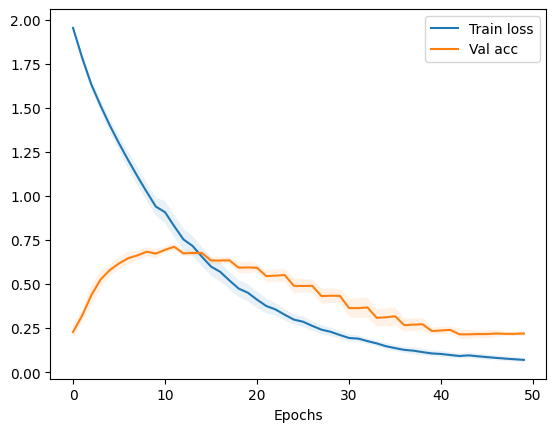

In [18]:

import matplotlib.pyplot as plt 

fig = plt.figure()
# temp_test_acc = train_loss.transpose(1, 0, 2)
# print(temp_test_acc.shape)

acc_means = np.mean(test_acc, axis=0)
acc_stds = np.std(test_acc, axis=0)

loss_means = np.mean(train_loss, axis=0)
loss_stds = np.std(train_loss, axis=0)

plt.plot(loss_means[:], label="Train loss")
plt.fill_between(range(len(loss_means[:])), loss_means[:] - loss_stds[:], loss_means[:] + loss_stds[:], alpha=0.1)


# for i in range(3):
    # plt.plot(test_acc[i,:10], label=f"Subset size: {subset_sizes[i]}")
plt.plot(acc_means[:], label="Val acc")
plt.fill_between(range(len(acc_means[:])), acc_means[:] - acc_stds[:], acc_means[:] + acc_stds[:], alpha=0.1)



plt.legend()
plt.xlabel("Epochs")
# plt.ylabel("Test Accuracy")
plt.show()



In [19]:
dataset = CoraGraphDataset()
g = dataset[0]
features = g.ndata["feat"]
labels = g.ndata["label"]
train_mask = g.ndata["train_mask"]
test_mask = g.ndata["test_mask"]
val_mask = g.ndata["val_mask"]

epochs = 50

seeds = [10,20,30,40]
dur = np.zeros((len(seeds), epochs))
test_acc = np.zeros((len(seeds), epochs))
train_loss = np.zeros((len(seeds), epochs))
nets = []
# E = torch.zeros(train_mask.shape[0])
# k = 60


for i_s, seed in enumerate(seeds):
    set_seed(seed)
    dataset = CoraGraphDataset()
    g = dataset[0]
    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    test_mask = g.ndata["test_mask"]
    val_mask = g.ndata["val_mask"]
    
    net = Net()
    optimizer = th.optim.Adam(net.parameters(), lr=1e-2)

    # Add edges between each node and itself to preserve old node representations
    g.add_edges(g.nodes(), g.nodes())
    E = torch.zeros(train_mask.shape[0])
    k = 60

    for epoch in range(50):
        if epoch >= 3:
            t0 = time.time()

        net.train()
        logits = net(g, features)
        logp = F.log_softmax(logits, 1)

        correct = torch.argmax(logp, dim=1) == labels
        correct[~(train_mask+val_mask)] = False
        E += correct

        loss = F.nll_loss(logp[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         if epoch >= 3:
#             dur.append(time.time() - t0)

        acc = evaluate(net, g, features, labels, val_mask)
        print(
            "Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f}".format(
                epoch, loss.item(), acc
            )
        )
        test_acc[i_s][epoch] = acc
        train_loss[i_s][epoch] = loss.item()
        nets.append(net)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 00000 | Loss 1.9627 | Test Acc 0.2600
Epoch 00001 | Loss 1.8065 | Test Acc 0.2960
Epoch 00002 | Loss 1.6638 | Test Acc 0.3580
Epoch 00003 | Loss 1.5515 | Test Acc 0.4780
Epoch 00004 | Loss 1.4401 | Test Acc 0.5840
Epoch 00005 | Loss 1.3439 | Test Acc 0.6220
Epoch 00006 | Loss 1.2535 | Test Acc 0.6500
Epoch 00007 | Loss 1.1632 | Test Acc 0.6620
Epoch 00008 | Loss 1.0734 | Test Acc 0.6680
Epoch 00009 | Loss 0.9869 | Test Acc 0.6840
Epoch 00010 | Loss 0.9045 | Test Acc 0.7060
Epoch 00011 | Loss 0.8273 | Test Acc 0.7220
Epoch 00012 | Loss 0.7560 | Test Acc 0.7280
Epoch 00013 | Loss 0.6909 | Test Acc 0.7400
Epoch 00014 | Loss 0

Epoch 00020 | Loss 0.3000 | Test Acc 0.7400
Epoch 00021 | Loss 0.2721 | Test Acc 0.7420
Epoch 00022 | Loss 0.2469 | Test Acc 0.7520
Epoch 00023 | Loss 0.2239 | Test Acc 0.7520
Epoch 00024 | Loss 0.2032 | Test Acc 0.7600
Epoch 00025 | Loss 0.1848 | Test Acc 0.7620
Epoch 00026 | Loss 0.1681 | Test Acc 0.7600
Epoch 00027 | Loss 0.1529 | Test Acc 0.7660
Epoch 00028 | Loss 0.1392 | Test Acc 0.7640
Epoch 00029 | Loss 0.1267 | Test Acc 0.7640
Epoch 00030 | Loss 0.1154 | Test Acc 0.7660
Epoch 00031 | Loss 0.1050 | Test Acc 0.7660
Epoch 00032 | Loss 0.0956 | Test Acc 0.7640
Epoch 00033 | Loss 0.0872 | Test Acc 0.7640
Epoch 00034 | Loss 0.0796 | Test Acc 0.7660
Epoch 00035 | Loss 0.0727 | Test Acc 0.7660
Epoch 00036 | Loss 0.0665 | Test Acc 0.7640
Epoch 00037 | Loss 0.0609 | Test Acc 0.7640
Epoch 00038 | Loss 0.0559 | Test Acc 0.7660
Epoch 00039 | Loss 0.0513 | Test Acc 0.7660
Epoch 00040 | Loss 0.0471 | Test Acc 0.7680
Epoch 00041 | Loss 0.0433 | Test Acc 0.7680
Epoch 00042 | Loss 0.0399 | Test

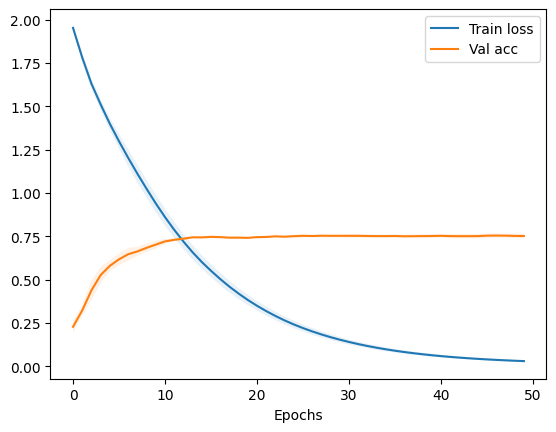

In [20]:

import matplotlib.pyplot as plt 

fig = plt.figure()
# temp_test_acc = train_loss.transpose(1, 0, 2)
# print(temp_test_acc.shape)

acc_means = np.mean(test_acc, axis=0)
acc_stds = np.std(test_acc, axis=0)

loss_means = np.mean(train_loss, axis=0)
loss_stds = np.std(train_loss, axis=0)

plt.plot(loss_means[:], label="Train loss")
plt.fill_between(range(len(loss_means[:])), loss_means[:] - loss_stds[:], loss_means[:] + loss_stds[:], alpha=0.1)


# for i in range(3):
    # plt.plot(test_acc[i,:10], label=f"Subset size: {subset_sizes[i]}")
plt.plot(acc_means[:], label="Val acc")
plt.fill_between(range(len(acc_means[:])), acc_means[:] - acc_stds[:], acc_means[:] + acc_stds[:], alpha=0.1)



plt.legend()
plt.xlabel("Epochs")
# plt.ylabel("Test Accuracy")
plt.show()



In [21]:
accs = []
for net in nets:
    accs.append(evaluate(net, g, features, labels, g.ndata['test_mask']))
f"OOD ACC: {np.mean(accs)} (+/-{np.std(accs)})"

'OOD ACC: 0.7402500000000001 (+/-0.011053845484717082)'

In [22]:
nets = []
# Add edges between each node and itself to preserve old node representations
epochs = 50

seeds = [10,20,30,40]
dur = np.zeros((len(seeds), epochs))
test_acc = np.zeros((len(seeds), epochs))
train_loss = np.zeros((len(seeds), epochs))

for i_s, seed in enumerate(seeds):
    set_seed(seed)
    dataset = CoraGraphDataset()
    g = dataset[0]
    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    test_mask = g.ndata["test_mask"]
    val_mask = g.ndata["val_mask"]
    
    net = Net()
    optimizer = th.optim.Adam(net.parameters(), lr=1e-2)

    # Add edges between each node and itself to preserve old node representations
    g.add_edges(g.nodes(), g.nodes())
    E = torch.zeros(train_mask.shape[0])
    k = 60

    for epoch in range(50):
        if epoch >= 3:
            t0 = time.time()

        net.train()
        logits = net(g, features)
        logp = F.log_softmax(logits, 1)

        correct = torch.argmax(logp, dim=1) == labels
        correct[~(train_mask+val_mask)] = False
        E += correct

        loss = F.nll_loss(logp[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         if epoch >= 3:
#             dur.append(time.time() - t0)

        if epoch % 3 == 0 and epoch != 0 and epoch < 45 and epoch > 5:
            true_idx = np.argwhere(train_mask + val_mask)[0]
            remove_idx = np.random.choice(true_idx, size=k, replace=False)

            g = dgl.remove_nodes(g, remove_idx)
            features = g.ndata["feat"]
            labels = g.ndata["label"]
            train_mask = g.ndata["train_mask"]
            val_mask = g.ndata["val_mask"]
            E = torch.zeros(train_mask.shape[0])
            k = int(0.9*k)
            print(sum(train_mask), sum(val_mask))

        acc = evaluate(net, g, features, labels, val_mask)
        print(
            "Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f}".format(
                epoch, loss.item(), acc
            )
        )
        test_acc[i_s][epoch] = acc
        train_loss[i_s][epoch] = loss.item()
        nets.append(net)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 00000 | Loss 1.9627 | Test Acc 0.2600
Epoch 00001 | Loss 1.8065 | Test Acc 0.2960
Epoch 00002 | Loss 1.6638 | Test Acc 0.3580
Epoch 00003 | Loss 1.5515 | Test Acc 0.4780
Epoch 00004 | Loss 1.4401 | Test Acc 0.5840
Epoch 00005 | Loss 1.3439 | Test Acc 0.6220
tensor(129) tensor(451)
Epoch 00006 | Loss 1.2535 | Test Acc 0.6452
Epoch 00007 | Loss 1.1764 | Test Acc 0.6585
Epoch 00008 | Loss 1.0865 | Test Acc 0.6630
tensor(118) tensor(408)
Epoch 00009 | Loss 0.9991 | Test Acc 0.6985
Epoch 00010 | Loss 0.9186 | Test Acc 0.7132
Epoch 00011 | Loss 0.8383 | Test Acc 0.7328
tensor(104) tensor(374)
Epoch 00012 | Loss 0.7640 | Test Acc 0.7299
Epoch 00013 | Loss 0.7103 | Test Acc 0.7326
Epoch 00014 | Loss 0.6481 | Test Acc 0.7353
tensor(98) tensor(337)
Epoch 00015 | Loss 0.5915 | Test Acc 0.7329
Epoch 00016 | Loss 

Epoch 00000 | Loss 1.9345 | Test Acc 0.1760
Epoch 00001 | Loss 1.7364 | Test Acc 0.3160
Epoch 00002 | Loss 1.5872 | Test Acc 0.5080
Epoch 00003 | Loss 1.4649 | Test Acc 0.5900
Epoch 00004 | Loss 1.3446 | Test Acc 0.6200
Epoch 00005 | Loss 1.2300 | Test Acc 0.6480
tensor(126) tensor(454)
Epoch 00006 | Loss 1.1244 | Test Acc 0.6674
Epoch 00007 | Loss 1.0118 | Test Acc 0.6674
Epoch 00008 | Loss 0.9266 | Test Acc 0.6762
tensor(117) tensor(409)
Epoch 00009 | Loss 0.8431 | Test Acc 0.6846
Epoch 00010 | Loss 0.7791 | Test Acc 0.6993
Epoch 00011 | Loss 0.7052 | Test Acc 0.7017
tensor(105) tensor(373)
Epoch 00012 | Loss 0.6351 | Test Acc 0.7024
Epoch 00013 | Loss 0.5653 | Test Acc 0.7051
Epoch 00014 | Loss 0.5141 | Test Acc 0.7105
tensor(95) tensor(340)
Epoch 00015 | Loss 0.4668 | Test Acc 0.7235
Epoch 00016 | Loss 0.4460 | Test Acc 0.7206
Epoch 00017 | Loss 0.4065 | Test Acc 0.7235
tensor(85) tensor(312)
Epoch 00018 | Loss 0.3703 | Test Acc 0.7212
Epoch 00019 | Loss 0.3567 | Test Acc 0.7212
Ep

In [23]:
accs = []
for net in nets:
    accs.append(evaluate(net, g, features, labels, g.ndata['test_mask']))
print(f"OOD ACC: {np.mean(accs)} (+/-{np.std(accs)})")

OOD ACC: 0.6894999999999999 (+/-0.012599603168354115)


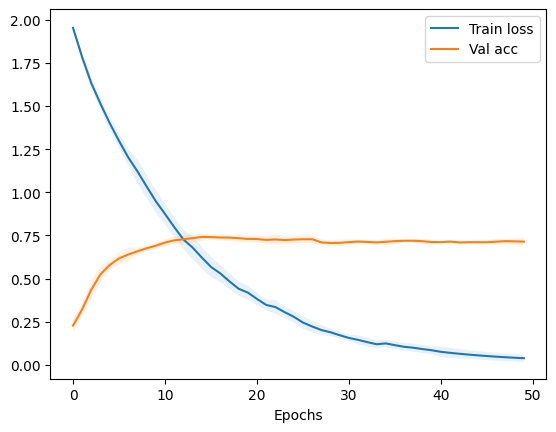

In [24]:

import matplotlib.pyplot as plt 

fig = plt.figure()
# temp_test_acc = train_loss.transpose(1, 0, 2)
# print(temp_test_acc.shape)

acc_means = np.mean(test_acc, axis=0)
acc_stds = np.std(test_acc, axis=0)

loss_means = np.mean(train_loss, axis=0)
loss_stds = np.std(train_loss, axis=0)

plt.plot(loss_means[:], label="Train loss")
plt.fill_between(range(len(loss_means[:])), loss_means[:] - loss_stds[:], loss_means[:] + loss_stds[:], alpha=0.1)


# for i in range(3):
    # plt.plot(test_acc[i,:10], label=f"Subset size: {subset_sizes[i]}")
plt.plot(acc_means[:], label="Val acc")
plt.fill_between(range(len(acc_means[:])), acc_means[:] - acc_stds[:], acc_means[:] + acc_stds[:], alpha=0.1)



plt.legend()
plt.xlabel("Epochs")
# plt.ylabel("Test Accuracy")
plt.show()

